<a href="https://colab.research.google.com/github/shivkumarganesh/Deep-Learning-Course/blob/main/Assignment-6/Part_B_Pytorch_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Updating the PIP

In [109]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

# Image Classification pyTorch import

In [110]:
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import zipfile

## Importing data from Kaggle

In [111]:
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [112]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [113]:
zf = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(zf, 'r')
zip_ref.extractall('/content/intel-image-classification')
zip_ref.close()

In [114]:
!ls '/content/intel-image-classification'

seg_pred  seg_test  seg_train


In [115]:
!ls '/content/intel-image-classification/seg_train/train'

buildings  forest  glacier  mountain  sea  street


# Defining Hyper-Parameters


In [116]:
EPOCH_SIZE=10
batch_size = 4

# Transforming the dataset to a specific size

In [117]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Scale((32,32)),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


# Preparation of Train Set

In [118]:
trainset = torchvision.datasets.ImageFolder(root="/content/intel-image-classification/seg_train/train", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Preparation of Test Set

In [119]:
testset = torchvision.datasets.ImageFolder(root="/content/intel-image-classification/seg_test/test", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Various Classes

In [120]:
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

# Visualiation of the images

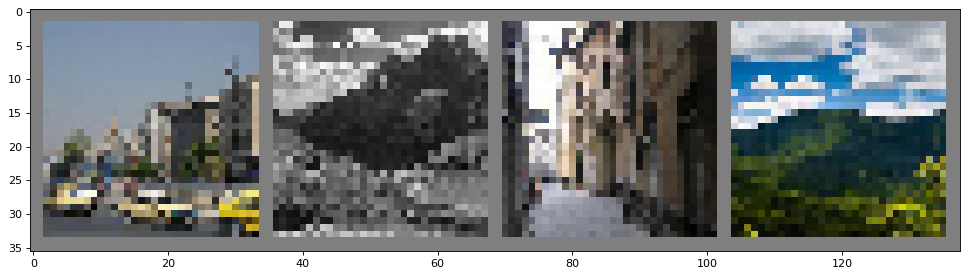

      street      glacier       street     mountain


In [121]:
def imshow(img):
    plt.figure(figsize=(15, 10), dpi = 80)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%12s' % classes[labels[j]] for j in range(batch_size)))

# Defining the Neural Network using Pytorch

In [122]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [123]:
net = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Running various epochs

In [124]:
for epoch in range(EPOCH_SIZE):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

[1,  2000] loss: 1.426
[2,  2000] loss: 0.975
[3,  2000] loss: 0.896
[4,  2000] loss: 0.811
[5,  2000] loss: 0.755
[6,  2000] loss: 0.712
[7,  2000] loss: 0.668
[8,  2000] loss: 0.627
[9,  2000] loss: 0.593
[10,  2000] loss: 0.544


# Final Prediction

In [125]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
try:
  print('--------------------')
  for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
except:
  print('--------------------')

--------------------
Accuracy of buildings : 62 %
Accuracy of forest : 93 %
Accuracy of glacier : 75 %
Accuracy of mountain : 76 %
Accuracy of   sea : 61 %
Accuracy of street : 75 %
--------------------
